## **Self-Organizing Map**

Self-Organizing Map (SOM) is a unsupervised algorithm which maps a lower dimension map to a higher dimension data.

One propurse could be clustering or even dimensionality reduction.

![SOM](https://github.com/rdenadai/AI-Study-Notebooks/tree/master/images/som.gif)

The map is build using a grid with nxn dimensions and each unit (neuron) of the map contains a value(s) with the dimension of the data. This way we are able to map a high dimension to a lower nxn dimension.

The self-organizing structure is given by moving each unit in the direction of the data points using some distance metric (like euclidian distance as is the most common).

Each epoch (or iteration), the points in the map are moving towards the clusters inside the data.

At the end, one should see the data topology using a U-Matrix.

All of these are implemented in this notebook.

In [1]:
import time
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count
from functools import partial
import numpy as np
try:
    import cupy as cp
except:
    print("Using cpu...")
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA
from sklearn.manifold import TSNE, MDS, SpectralEmbedding
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs, load_iris
from sklearn.neighbors import KDTree

import torch
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
print(device)

%matplotlib inline
%load_ext cython

Using cpu...


In [0]:
colors = np.asarray([
    (230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), (70, 240, 240),
    (240, 50, 230), (210, 245, 60), (250, 190, 190), (0, 128, 128), (230, 190, 255), (170, 110, 40), (255, 250, 200),
    (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (0, 0, 0),
    (141, 204, 226), (212, 50, 147), (251, 226, 93), (16, 185, 176), (189, 182, 163), (244, 172, 18), (100, 28, 112),
    (165, 124, 92), (183, 160, 211), (66, 47, 105), (240, 67, 7), (244, 188, 198)
]).astype(np.float32) / 255.0

def make_colors(y_train, y_pred, colors):  
    cl_train = colors[:len(set(y_train))]
    cl_pred = colors[:len(set(y_pred))]
    c_y_train = [cl_train[y] if y >= 0 else [0.50196078, 0.50196078, 0.50196078] for y in y_train]
    c_y_pred = [cl_pred[y] if y >= 0 else [0.50196078, 0.50196078, 0.50196078] for y in y_pred]
    return c_y_train, c_y_pred

### Implementation

 - The implementation uses cython and python multiprocessing to improve the performance in calculate SOM.

 - The distance metric used is the euclidian distance.

 - This implementation uses a decay rate to lower the learning rate and neighbour units after some define number of iterations (given by the iter_decay).

 - There's still no implementation of clustering... yet...

In [0]:
%%cython

import numpy as np
cimport numpy as npc

cpdef npc.ndarray euclidian(npc.ndarray a, npc.ndarray b, int axis=-1):
    return np.sqrt(np.sum(np.square(a - b), axis=axis))

cpdef calculate_theta(dst, dem):
     return np.mean(np.exp(-((np.square(dst))/dem)))

In [0]:
def find_neighbourhood(BMU, lattice, radius=5):
    K = np.arange(1.5, 50, 1.5)[radius-1]
    tree = KDTree(lattice, leaf_size=2)
    all_nn_indices = tree.query_radius([BMU], r=K, return_distance=False)
    pts = np.unique(lattice[all_nn_indices[0]], axis=0)
    obj = np.where((pts[:, 0] == BMU[0]) & (pts[:, 1] == BMU[1]))
    return np.delete(pts, obj[0][0], 0)

def calculate_and_adjust_neighbourhood(xi, W, BMU_node, lr, dem, ng):
    indx = tuple(np.split(ng, 2))
    ngb_node = W[indx]
    dst_n = euclidian(BMU_node, ngb_node, axis=-1)
    theta = calculate_theta(dst_n, dem)
    return indx, W[indx] + (theta * (lr * (xi - ngb_node)))


class SOM:
    
    def __init__(self, units=15, lr=0.5, radius=5, verbose=False):
        self.units = units
        self._lr = lr
        self._sig = 1
        self._radius = radius
        self.W = np.ones((self.units, self.units, 1)).ravel()
        self.verbose = verbose
    
    def train(self, x, epochs=200, batch_size=32, iter_decay=25):
        qtd, self._size = x.shape
        # Define the Units Weights
        mn, mx = np.min(x), np.max(x)
        # Create the units (neurons) in the space as a 2D grid
        space = np.linspace(mn, mx, self.units)
        self.W = np.ones((self.units, self.units, self._size)).ravel()
        self.W = self.W.reshape(self.units, self.units, self._size)
        for m in range(self.units):
            for j in range(self._size):
                if j == 0:
                    self.W[:, m, j] = self.W[:, m, j] * space
                elif j == self._size-1:
                    self.W[:, m, j] = self.W[:, m, j] * space[m]
                else:
                    self.W[:, m, j] = self.W[:, m, j]# * np.random.uniform(1e-3, 1)
        # Create a lattice matrix to find the Neighbourhood of a BMU
        idx = np.indices(self.W.shape[:2])
        idx = np.vstack([ix.flatten() for ix in idx])
        self._lattice = np.stack([ix for ix in idx], axis=1)
        # Running epochs!
        start = time.time()
        n_samples = int(batch_size / 2)
        mb = np.ceil(x.shape[0] / batch_size).astype(np.int32)
        with ProcessPoolExecutor(max_workers=cpu_count()) as exc:
            for epoch in range(epochs):
                X = shuffle(np.copy(x), replace=True)
                r = 0
                for _ in range(mb):
                    # Mini batch crop
                    ini, end = r * batch_size, (r + 1) * batch_size
                    samples = X[ini:end, :]
                    if len(samples) > n_samples:
                        batch_X = shuffle(samples, n_samples=n_samples)
                    else:
                        batch_X = samples
                    r += 1
                    for xi in batch_X:
                        # Find the BMU of the point
                        dist = euclidian(xi, self.W, axis=-1)
                        BMU = np.asarray(np.where(dist==np.min(dist))).ravel()[:2]
                        # If found a BMU
                        if BMU is not None:
                            # Find Neighbourhood of BMU using lattice matrix
                            ngb = find_neighbourhood(BMU, self._lattice, self._radius)
                            # Neighbourhood update
                            BMU_node = self.W[tuple(BMU)]
                            dem = (2*(np.square(self._sig)))
                            # Multiprocess module
                            fn = partial(calculate_and_adjust_neighbourhood, xi, self.W, BMU_node, self._lr, dem)
                            for ng in exc.map(fn, ngb, chunksize=10):
                                self.W[ng[0]] = ng[1]
                            # BMU update
                            self.W[tuple(BMU)] += (self._lr * (xi - BMU_node))
                if (epoch % iter_decay == 0 and epoch > 0) or epoch == epochs - 1:
                    decay = np.exp(-epoch/epochs)
                    # Learning rate decay
                    self._lr *= decay
                    self._sig = self._radius * decay
                    if self._radius > 1:
                        self._radius = int(np.ceil(self._radius * decay))
                    else:
                        self._radius = 1
                    if self.verbose:
                        print(f"epoch [{epoch}/{epochs}] <=> Running time: {time.time() - start}")
    
    def predict(self, x):
        pass

    def umatrix(self):
        s = self.W.shape[0]
        umatrix = np.zeros((s, s))
        for lat in self._lattice:
            ngb = find_neighbourhood(lat, self._lattice, 1)
            xi = self.W[tuple(lat)]
            for ng in ngb:
                xt = np.array([self.W[tuple(ng)]])
                umatrix[tuple(ng)] += euclidian(xi, xt)
        umatrix = (MinMaxScaler().fit_transform(umatrix) * 255).astype(np.int)
        return np.rot90(np.invert(umatrix))

### **Toy datasets provided by scikit-learn**

To initialy test and visualize what a SOM do, we are going to use toy datasets provided by scikit-learn.

Later on this notebook is explored a way to create a latent space of the MNIST dataset using Autoencoders and the apply SOM on the result.

#### 3D Blobs

In [256]:
scaler = MinMaxScaler()

x, y = make_blobs(128, n_features=3, centers=3, random_state=42)
x = scaler.fit_transform(x)

som = SOM(verbose=True)
som.train(x)
W = som.W.flatten().reshape(-1, 3)
umatrix = som.umatrix()

epoch [25/200] <=> Running time: 10.0800302028656
epoch [50/200] <=> Running time: 19.663402795791626
epoch [75/200] <=> Running time: 27.182862281799316
epoch [100/200] <=> Running time: 33.35936117172241
epoch [125/200] <=> Running time: 37.36079931259155
epoch [150/200] <=> Running time: 41.348073959350586
epoch [175/200] <=> Running time: 43.851285219192505
epoch [199/200] <=> Running time: 46.130627155303955


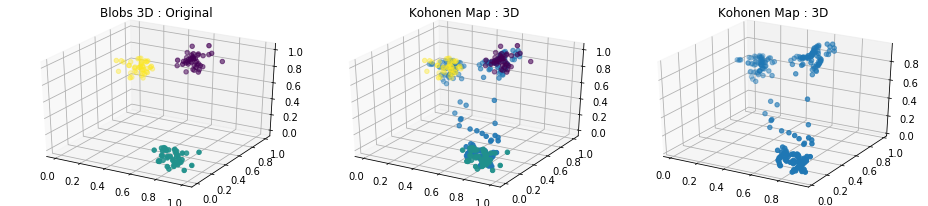

In [257]:
plt.figure(figsize=(13, 3))
ax = plt.subplot(1, 3, 1, projection='3d')
plt.title("Blobs 3D : Original")
ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y)
ax = plt.subplot(1, 3, 2, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y)
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
ax = plt.subplot(1, 3, 3, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

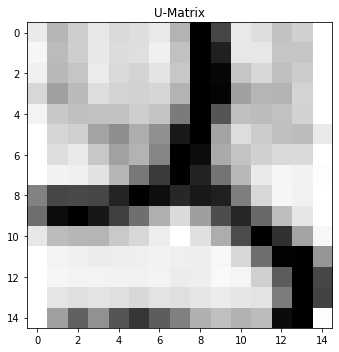

In [258]:
plt.figure(figsize=(5, 5))
plt.subplot(1, 1, 1)
plt.title("U-Matrix")
plt.imshow(umatrix, cmap="gray")
plt.tight_layout()
plt.show()

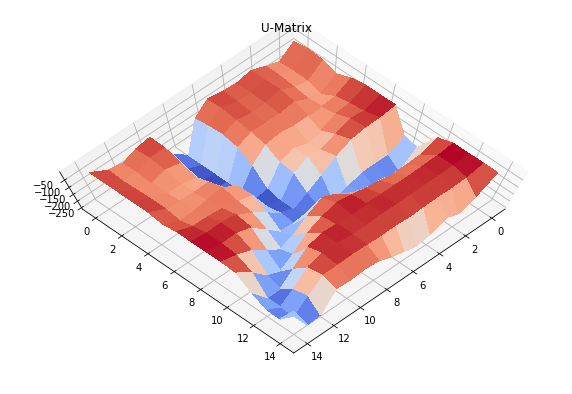

In [259]:
s = np.arange(0, som.units)
x, y = np.meshgrid(s, s)

fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
plt.title("U-Matrix")
ax.view_init(80, 45)
surf = ax.plot_surface(x, y, umatrix, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

#### 2D Blobs

epoch [25/200] <=> Running time: 6.300544500350952
epoch [50/200] <=> Running time: 11.740918159484863
epoch [75/200] <=> Running time: 15.853654384613037
epoch [100/200] <=> Running time: 18.906008005142212
epoch [125/200] <=> Running time: 20.929914236068726
epoch [150/200] <=> Running time: 23.021363973617554
epoch [175/200] <=> Running time: 24.241161108016968
epoch [199/200] <=> Running time: 25.426844835281372


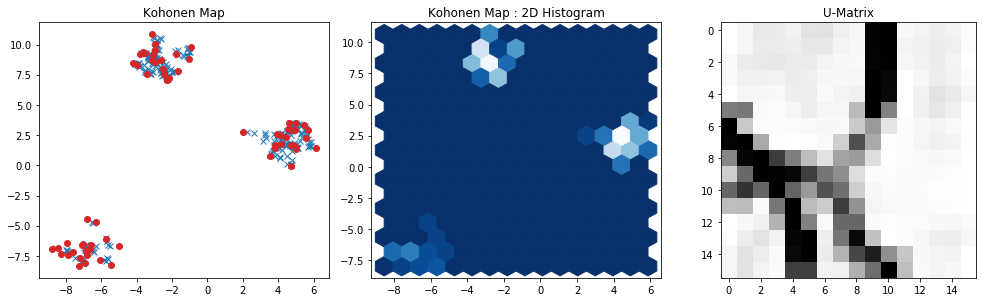

In [260]:
x, y = make_blobs(64, n_features=2, centers=3, random_state=42)

som = SOM(units=16, verbose=True)
som.train(x)
W = som.W.flatten().reshape(-1, 2)
umatrix = som.umatrix()

fig = plt.figure(figsize=(14, 8))
plt.subplot(2, 3, 1)
plt.title("Kohonen Map")
plt.plot(W[:, 0], W[:, 1], 'x', c='C0')
plt.plot(x[:, 0], x[:, 1], 'o', c='C3')
plt.subplot(2, 3, 2)
plt.title("Kohonen Map : 2D Histogram")
plt.hexbin(W[:, 0], W[:, 1], gridsize=15, cmap=plt.cm.Blues_r)
plt.subplot(2, 3, 3)
plt.title("U-Matrix")
plt.imshow(umatrix, cmap="gray")
plt.tight_layout()
plt.show()

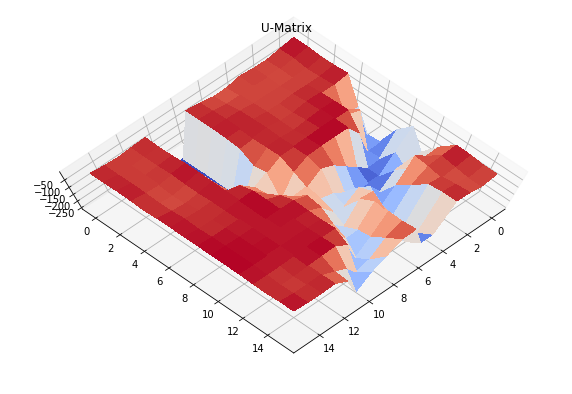

In [261]:
s = np.arange(0, som.units)
x, y = np.meshgrid(s, s)

fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
plt.title("U-Matrix")
ax.view_init(80, 45)
surf = ax.plot_surface(x, y, umatrix, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

#### Two Moons (2D)

In [0]:
X, y = make_moons(500, noise=0.065)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

som = SOM(units=25)
som.train(X_train)
W = som.W.flatten().reshape(-1, 2)
umatrix = som.umatrix()

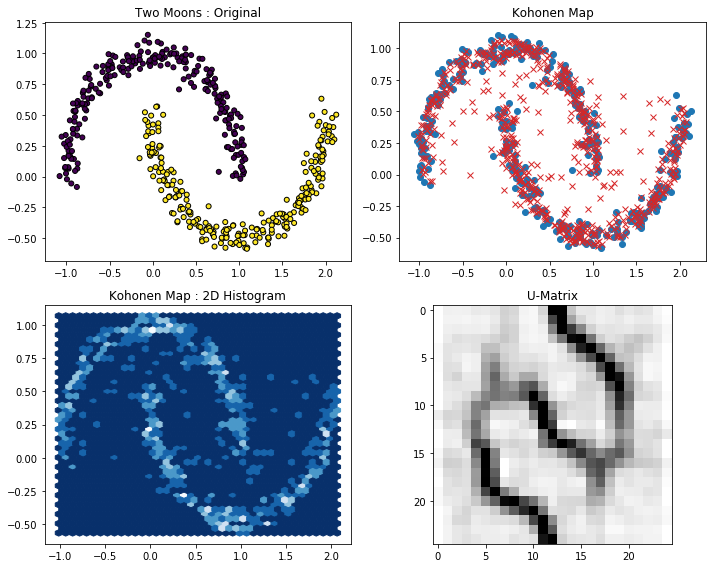

In [274]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Two Moons : Original")
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hexbin(W[:, 0], W[:, 1], gridsize=40, cmap=plt.cm.Blues_r)
plt.subplot(2, 2, 4)
plt.title("U-Matrix")
plt.imshow(umatrix, cmap="gray")
plt.tight_layout()
plt.show()

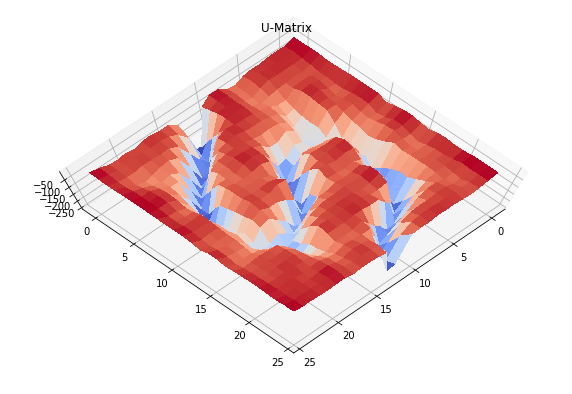

In [275]:
s = np.arange(0, som.units)
x, y = np.meshgrid(s, s)

fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
plt.title("U-Matrix")
ax.view_init(80, 45)
surf = ax.plot_surface(x, y, umatrix, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

#### Another 2D Blobs

In [0]:
X, y = make_classification(n_samples=500, n_features=2, n_classes=3, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

som = SOM(units=30)
som.train(X_train)
W = som.W.flatten().reshape(-1, 2)
umatrix = som.umatrix()

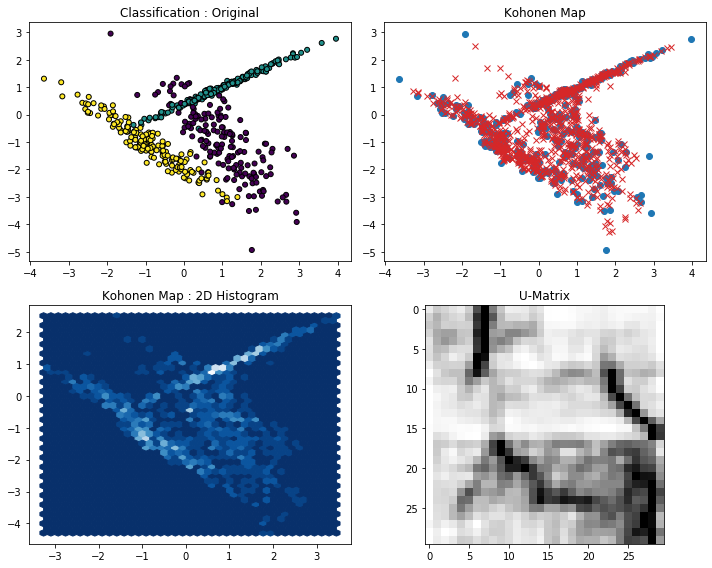

In [151]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Classification : Original")
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hexbin(W[:, 0], W[:, 1], gridsize=40, cmap=plt.cm.Blues_r)
plt.subplot(2, 2, 4)
plt.title("U-Matrix")
plt.imshow(umatrix, cmap="gray")
plt.tight_layout()
plt.show()

#### Another 3D Blobs

In [0]:
X, y = make_classification(n_samples=500, n_features=3, n_classes=3, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

som = SOM(units=30)
som.train(X_train)
W = som.W.flatten().reshape(-1, 3)
umatrix = som.umatrix()

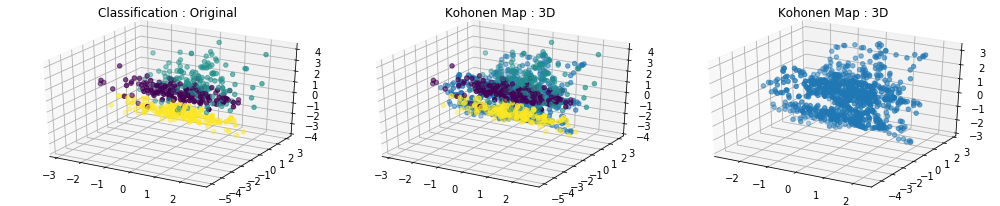

In [153]:
plt.figure(figsize=(14, 3))
ax = plt.subplot(1, 3, 1, projection='3d')
plt.title("Classification : Original")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
ax = plt.subplot(1, 3, 2, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
ax = plt.subplot(1, 3, 3, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

#### Rings (2D)

In [0]:
X, y = make_circles(500, noise=0.05, factor=.33)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

som = SOM(units=30)
som.train(X_train)
W = som.W.flatten().reshape(-1, 2)
umatrix = som.umatrix()

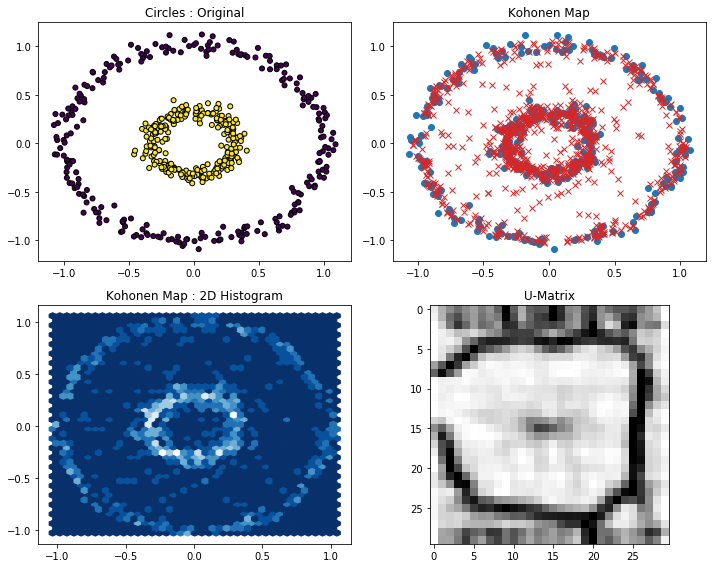

In [155]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Circles : Original")
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hexbin(W[:, 0], W[:, 1], gridsize=40, cmap=plt.cm.Blues_r)
plt.subplot(2, 2, 4)
plt.title("U-Matrix")
plt.imshow(umatrix, cmap="gray")
plt.tight_layout()
plt.show()

#### Clusters of Blobs

In [0]:
X, y = make_blobs(500, n_features=2, centers=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

som = SOM(units=30)
som.train(X_train)
W = som.W.flatten().reshape(-1, 2)
umatrix = som.umatrix()

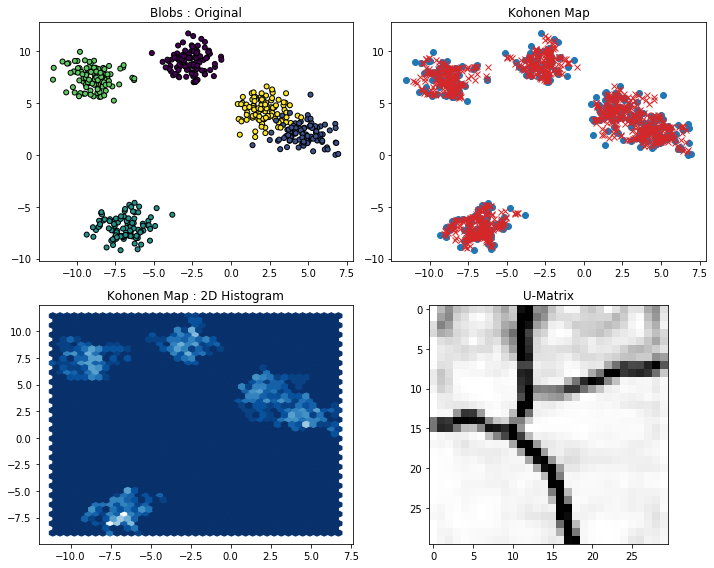

In [157]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Blobs : Original")
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hexbin(W[:, 0], W[:, 1], gridsize=40, cmap=plt.cm.Blues_r)
plt.subplot(2, 2, 4)
plt.title("U-Matrix")
plt.imshow(umatrix, cmap="gray")
plt.tight_layout()
plt.show()

#### 3D Clusters of Blobs

In [0]:
X, y = make_blobs(500, n_features=3, centers=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

som = SOM(units=30)
som.train(X_train)
W = som.W.flatten().reshape(-1, 3)

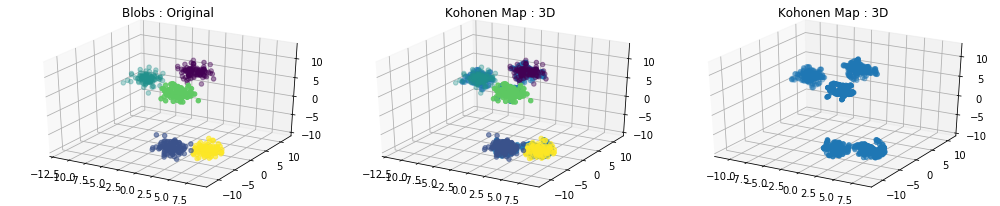

In [159]:
plt.figure(figsize=(14, 3))
ax = plt.subplot(1, 3, 1, projection='3d')
plt.title("Blobs : Original")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
ax = plt.subplot(1, 3, 2, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
ax = plt.subplot(1, 3, 3, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

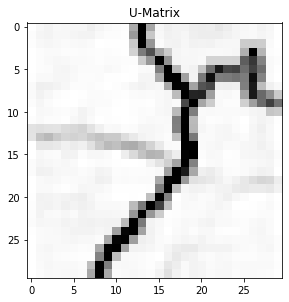

In [160]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 4)
plt.title("U-Matrix")
plt.imshow(som.umatrix(), cmap="gray")
plt.tight_layout()
plt.show()

## **Self-organizing map on IRIS**

In [0]:
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

x_pca = StandardScaler().fit_transform(X_iris)
x_pca = TruncatedSVD(n_components=2, random_state=42).fit_transform(x_pca)

som = SOM(units=20)
som.train(x_pca)
W = som.W.flatten().reshape(-1, 2)
umatrix = som.umatrix()

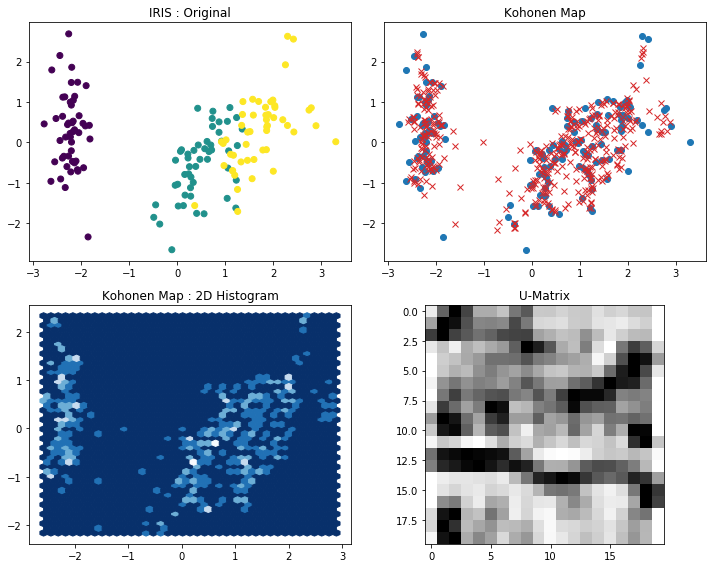

In [162]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("IRIS : Original")
plt.scatter(x_pca[:, 0], x_pca[:, 1], marker='o', c=y_iris)
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(x_pca[:, 0], x_pca[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hexbin(W[:, 0], W[:, 1], gridsize=40, cmap=plt.cm.Blues_r)
plt.subplot(2, 2, 4)
plt.title("U-Matrix")
plt.imshow(umatrix, cmap="gray")
plt.tight_layout()
plt.show()

### **Self-organizing map on MNIST**


Loading MNIST from scikit-learn to test out against the Self-Organizing Map.

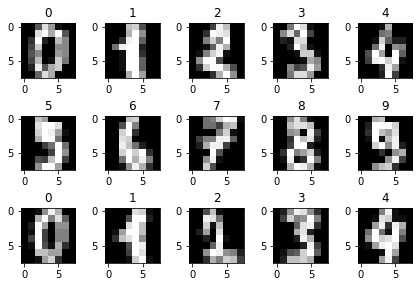

In [163]:
digits = load_digits(n_class=10)
x = digits.data
y = digits.target

for i in range(15):
    img, title = x[i], y[i]
    plt.subplot(3, 5, i + 1)
    plt.title(title.item())
    plt.imshow(img.reshape(8, 8), cmap="gray")
plt.tight_layout()
plt.show()

#### MNIST : PCA (2D)

In [0]:
x_pca = StandardScaler().fit_transform(x)
x_pca = TruncatedSVD(n_components=2, random_state=42).fit_transform(x_pca)

som = SOM(units=30)
som.train(x_pca)
W = som.W.flatten().reshape(-1, 2)
umatrix = som.umatrix()

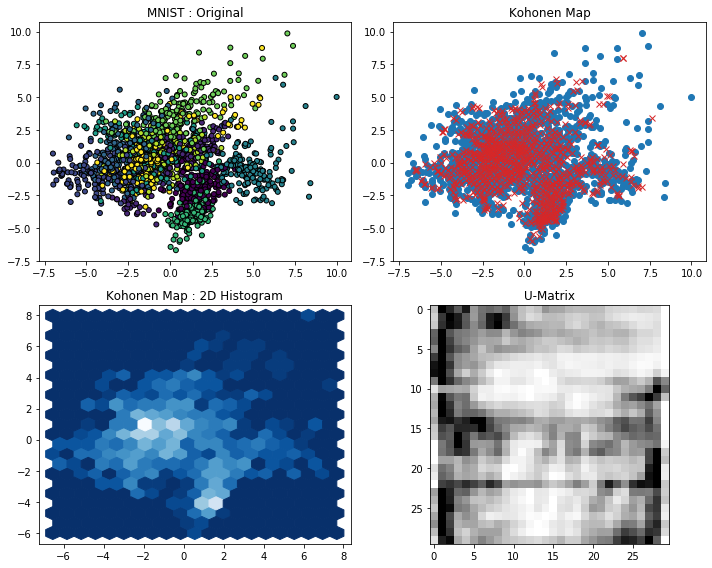

In [165]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("MNIST : Original")
plt.scatter(x_pca[:, 0], x_pca[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(x_pca[:, 0], x_pca[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hexbin(W[:, 0], W[:, 1], gridsize=20, cmap=plt.cm.Blues_r)
plt.subplot(2, 2, 4)
plt.title("U-Matrix")
plt.imshow(umatrix, cmap="gray")
plt.tight_layout()
plt.show()

#### MNIST : PCA (3D)

In [0]:
x_pca = StandardScaler().fit_transform(x)
x_pca = TruncatedSVD(n_components=3, random_state=42).fit_transform(x_pca)

som = SOM(units=25)
som.train(x_pca)
W = som.W.flatten().reshape(-1, 3)

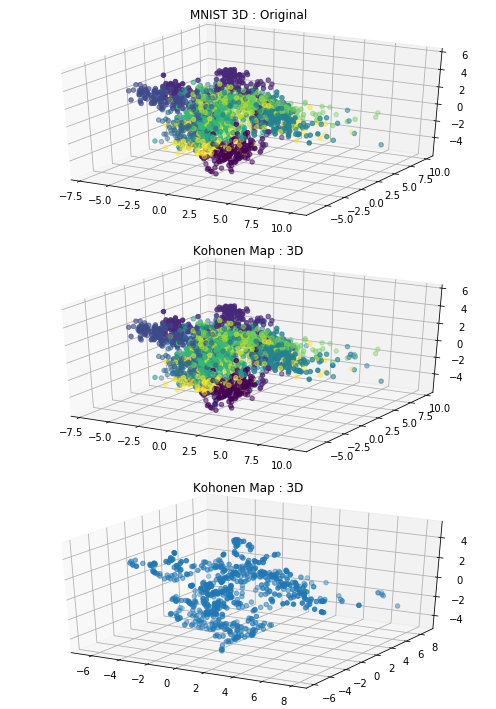

In [167]:
plt.figure(figsize=(14, 3))
ax = plt.subplot(1, 3, 1, projection='3d')
plt.title("MNIST 3D : Original")
ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=y)
ax = plt.subplot(1, 3, 2, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=y)
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
ax = plt.subplot(1, 3, 3, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

### MNIST : t-SNE (2D)

In [0]:
x_tsne = TSNE(n_components=2, perplexity=15, init='pca', random_state=0).fit_transform(x)
x_tsne = StandardScaler().fit_transform(x_tsne)

som = SOM(units=25)
som.train(x_tsne)
W = som.W.flatten().reshape(-1, 2)
umatrix = som.umatrix()

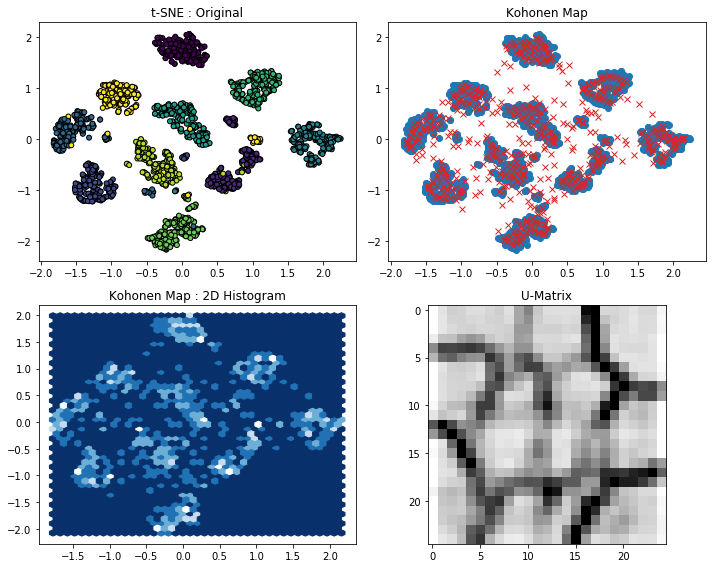

In [169]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("t-SNE : Original")
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.subplot(2, 2, 2)
plt.title("Kohonen Map")
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], marker='o', c='C0')
plt.plot(W[:, 0], W[:, 1], 'x', c='C3')
plt.subplot(2, 2, 3)
plt.title("Kohonen Map : 2D Histogram")
plt.hexbin(W[:, 0], W[:, 1], gridsize=40, cmap=plt.cm.Blues_r)
plt.subplot(2, 2, 4)
plt.title("U-Matrix")
plt.imshow(umatrix, cmap="gray")
plt.tight_layout()
plt.show()

### MNIST : t-SNE (3D)

In [0]:
x_tsne = TSNE(n_components=3, perplexity=15, init='pca', random_state=0).fit_transform(x)
x_tsne = StandardScaler().fit_transform(x_tsne)

som = SOM(units=25)
som.train(x_tsne)
W = som.W.flatten().reshape(-1, 3)
umatrix = som.umatrix()

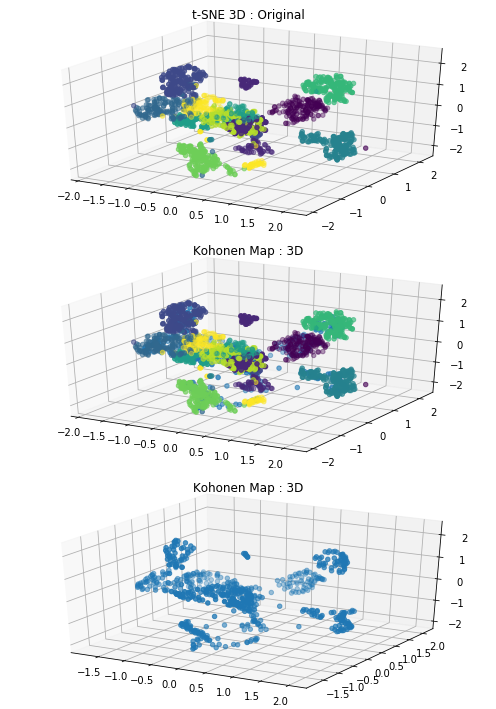

In [171]:
plt.figure(figsize=(7, 10))
ax = plt.subplot(3, 1, 1, projection='3d')
plt.title("t-SNE 3D : Original")
ax.scatter(x_tsne[:, 0], x_tsne[:, 1], x_tsne[:, 2], c=y)
ax = plt.subplot(3, 1, 2, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(x_tsne[:, 0], x_tsne[:, 1], x_tsne[:, 2], c=y)
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
ax = plt.subplot(3, 1, 3, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

### **Autoencoder**

Taken from and modified version from : [Autoencoder in Pytorch](https://reyhaneaskari.github.io/AE.htm)

The problem with the above techniques is that it works fine with a low dimensional image, like the toy MNIST provided by scikit-learn.

If one try with the MNIST dataset provided by pytorch, well... its a little differente history.

In [172]:
transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
qmnist_trainset = datasets.QMNIST(root='./data', what="test50k", train=True, download=True, transform=transform)
qmnist_testset = datasets.QMNIST(root='./data', what="test50k", train=False, download=True, transform=transform_test)

trainset = torch.utils.data.ConcatDataset([mnist_trainset, qmnist_trainset])
testset = torch.utils.data.ConcatDataset([mnist_testset, qmnist_testset])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
testloader  = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=4)

0it [00:00, ?it/s]

9920512it [00:06, 1588962.93it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 137448.71it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2260738.83it/s]                            
  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 54156.22it/s]            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


9748480it [00:00, 25438372.78it/s]         
0it [00:00, ?it/s]

532480it [00:00, 2204021.03it/s]          


Processing...


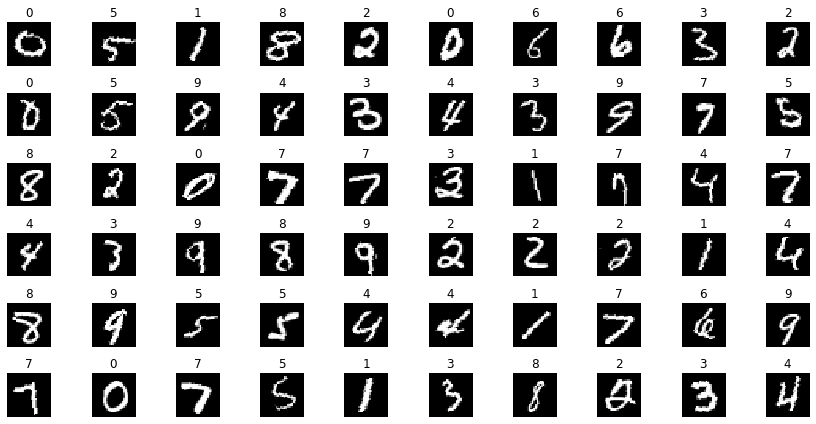

In [173]:
plt.figure(figsize=(12, 6))
for i in range(60):
    idx = [np.random.choice(len(trainset), 1, replace=False)][0][0]
    img, title = trainset[idx]
    plt.subplot(6, 10, i + 1)
    plt.title(title)
    plt.imshow(img[0, :, :].numpy(), cmap="gray")
    plt.axis('off')
plt.tight_layout()
plt.show()

#### Autoencoder network

In [0]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

    
class UnFlatten(nn.Module):
    def forward(self, input, size=64):
        return input.view(input.size(0), size, 2, 2)

    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 128, 3, stride=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),
            Flatten(),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Linear(64, 10),
        )

        self.decoder = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(True),
            nn.Linear(64, 256),
            UnFlatten(),
            nn.ConvTranspose2d(64, 128, 3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 8, 5, stride=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)


model = Autoencoder().to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4, weight_decay=1e-5)

model_filename = "best_model.dp"

#### Training step

In [175]:
x_img, xh_img = [], []

start = time.time()
best_loss = 1e+10
num_epochs = 21
for epoch in range(num_epochs):
    for data in trainloader:
        inputs, labels = data
        # ===================forward=====================
        outputs = model(inputs.to(device))
        loss = criterion(outputs.to(device), inputs.to(device))
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================save examples====================
    idxs = [np.random.choice(inputs.shape[0], 5, replace=False)]
    x_img += [to_img(inputs[idx].cpu().data) for idx in idxs]
    xh_img += [to_img(outputs[idx].cpu().data) for idx in idxs]
    # ===================save model====================
    if loss <= best_loss:
        best_loss = loss
        torch.save({
            'model': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
        }, model_filename)

    # ===================log========================
    if epoch % 1 == 0:
        tm = time.time() - start
        print('[%d/%d] loss: %.10f, time: %.2f' % (epoch + 1, num_epochs,  loss, tm))
        start = time.time()
        # save_image(x, './x_{}.png'.format(epoch))
        # save_image(x_hat, './x_hat_{}.png'.format(epoch))

[1/21] loss: 0.1966524720, time: 23.61
[2/21] loss: 0.1576950103, time: 22.83
[3/21] loss: 0.1423753500, time: 23.08
[4/21] loss: 0.1070745364, time: 23.18
[5/21] loss: 0.1161808446, time: 22.94
[6/21] loss: 0.1033642441, time: 22.16
[7/21] loss: 0.1068933606, time: 22.94
[8/21] loss: 0.1079141647, time: 22.54
[9/21] loss: 0.0915218294, time: 23.32
[10/21] loss: 0.0962715074, time: 22.60
[11/21] loss: 0.0920675248, time: 22.45
[12/21] loss: 0.0759960860, time: 23.04
[13/21] loss: 0.1056505293, time: 24.24
[14/21] loss: 0.0813286826, time: 22.70
[15/21] loss: 0.0814369097, time: 22.88
[16/21] loss: 0.0928150266, time: 23.07
[17/21] loss: 0.0717718676, time: 22.73
[18/21] loss: 0.0854445398, time: 22.25
[19/21] loss: 0.0697054118, time: 23.17
[20/21] loss: 0.0856528282, time: 22.19
[21/21] loss: 0.0637218356, time: 23.09


#### Results

The first line is the ground truth values and the line bellow is the decoded version... each column represents an epoch!


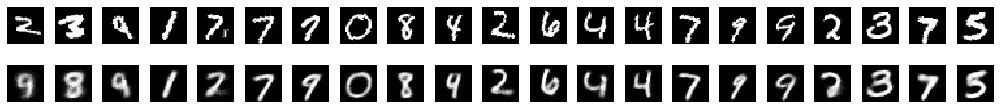

In [178]:
cols = len(x_img)

plt.figure(figsize=(14, 5))
for i, xi in enumerate(x_img):
    ax = plt.subplot(6, cols, i + 1)
    ax.imshow(xi[0, 0, :], cmap="gray")
    ax.axis('off')
for i, xhi in enumerate(xh_img):
    ax = plt.subplot(6, cols, i + cols + 1)
    ax.imshow(xhi[0, 0, :], cmap="gray")
    ax.axis('off')
plt.tight_layout()
plt.show()

Bellow i'm just loading the best saved model!

In [0]:
model = Autoencoder().to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4, weight_decay=1e-5)

checkpoint = torch.load(model_filename, map_location=device)
model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])

Now let's generated the "predicted" version from our test data and also, generate the latent space and reserve that to be used in the SOM!

In [0]:
y_img, yh_img = [], []
outputs, labels = [], []
for data in testloader:
    inputs, lbs = data
    
    y_outputs = model(inputs.to(device))
    idx = [np.random.choice(inputs.shape[0], 1, replace=False)]
    y_img += [to_img(inputs[idx].cpu().data)]
    yh_img += [to_img(y_outputs[idx].cpu().data)]
    
    outs = model.encode(inputs.to(device)).cpu().data.numpy()
    outputs += list(outs)
    labels += list(lbs.numpy().ravel())
outputs, labels = np.asarray(outputs), np.asarray(labels)

The first 3 lines are the ground truth of tests and the rest is de decoded version... Looks like it do 2 mistakes in this small data visualization but in general looks fine!

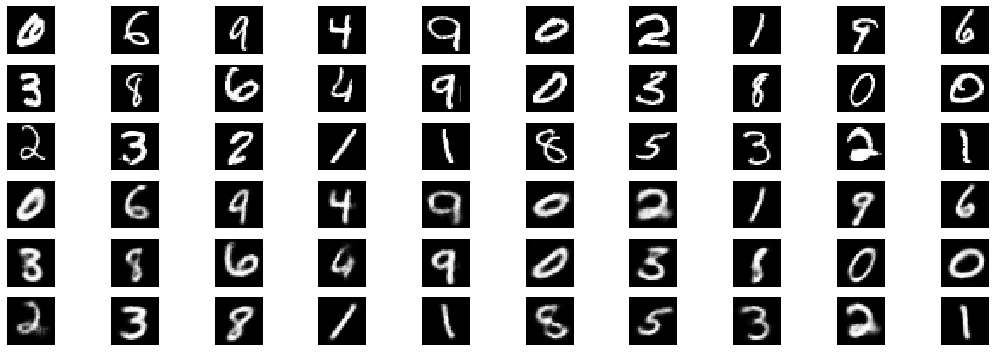

In [181]:
plt.figure(figsize=(15, 5))
for i, yi in enumerate(y_img[:30]):
    plt.subplot(6, 10, i + 1)
    plt.imshow(yi[0, 0, :], cmap="gray")
    plt.axis('off')
for i, yhi in enumerate(yh_img[:30]):
    plt.subplot(6, 10, i + 31)
    plt.imshow(yhi[0, 0, :], cmap="gray")
    plt.axis('off')
plt.tight_layout()
plt.show()

Let's use **t-SNE** to do a dimensionality reduction before pass to the SOM.

In [234]:
S = 1500

mds_labels = labels[:S]

# x_trans = MDS(
#     n_components=3,
#     n_init=20,
#     max_iter=3000,
#     n_jobs=cpu_count(),
#     random_state=0
# ).fit_transform(outputs[:S])
# x_trans = MinMaxScaler().fit_transform(x_trans)

# x_trans = SpectralEmbedding(
#     n_components=3,
#     affinity="rbf",
#     gamma=1e-4,
#     n_neighbors=10,
#     n_jobs=cpu_count(),
#     random_state=0
# ).fit_transform(outputs[:S])
# x_trans = MinMaxScaler().fit_transform(x_trans)

x_trans = TSNE(
    n_components=3,
    perplexity=12,
    init='pca',
    n_iter=2500,
    random_state=0
).fit_transform(outputs[:S])
x_trans = MinMaxScaler().fit_transform(x_trans)

som = SOM(units=20, verbose=True)
som.train(x_trans, epochs=100)
W = som.W.flatten().reshape(-1, 3)
umatrix = som.umatrix()

epoch [25/100] <=> Running time: 136.45961928367615
epoch [50/100] <=> Running time: 235.25226640701294
epoch [75/100] <=> Running time: 309.74252247810364
epoch [99/100] <=> Running time: 358.7991991043091


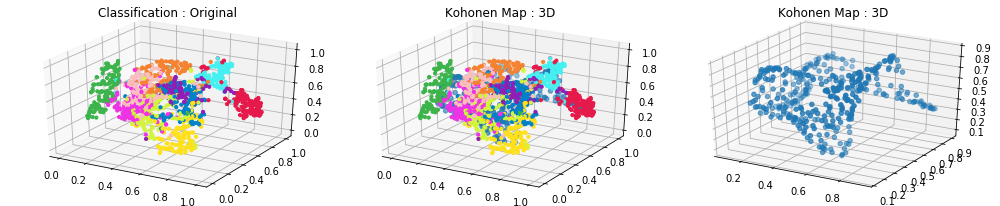

In [235]:
y_color = make_colors(mds_labels, mds_labels, colors)[0]

plt.figure(figsize=(14, 3))
ax = plt.subplot(1, 3, 1, projection='3d')
plt.title("Classification : Original")
ax.scatter(x_trans[:, 0], x_trans[:, 1], x_trans[:, 2], c=y_color, alpha=1, s=10)
ax = plt.subplot(1, 3, 2, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(x_trans[:, 0], x_trans[:, 1], x_trans[:, 2], c=y_color, alpha=1, s=10)
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
ax = plt.subplot(1, 3, 3, projection='3d')
plt.title("Kohonen Map : 3D")
ax.scatter(W[:, 0], W[:, 1], W[:, 2], cmap=plt.cm.Blues_r)
plt.tight_layout()
plt.show()

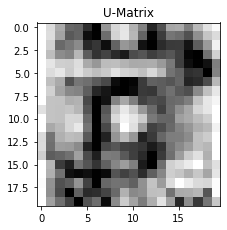

In [236]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 4)
plt.title("U-Matrix")
plt.imshow(umatrix, cmap="gray")
plt.tight_layout()
plt.show()

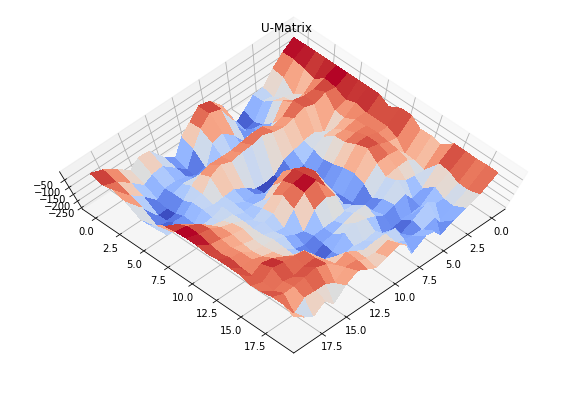

In [237]:
s = np.arange(0, som.units)
x, y = np.meshgrid(s, s)

fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
plt.title("U-Matrix")
ax.view_init(80, 45)
surf = ax.plot_surface(x, y, umatrix, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

Results are not very good... but we can see some clusters in the reduced data... let's run the SOM in the original 10 dim latent space generated by the Autoencoder and see if it performs better!

In [249]:
S = 1500
x_labels = labels[:S]
x_trans = outputs[:S]

som = SOM(verbose=True)
som.train(x_trans)
W = som.W.flatten().reshape(-1, 10)
umatrix = som.umatrix()

epoch [25/200] <=> Running time: 170.36671614646912
epoch [50/200] <=> Running time: 311.32559609413147
epoch [75/200] <=> Running time: 420.83449244499207
epoch [100/200] <=> Running time: 500.99005818367004
epoch [125/200] <=> Running time: 553.0462336540222
epoch [150/200] <=> Running time: 604.6043317317963
epoch [175/200] <=> Running time: 635.0623729228973
epoch [199/200] <=> Running time: 664.0316405296326


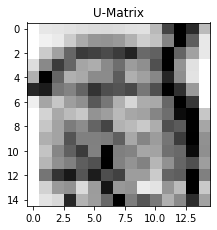

In [250]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 4)
plt.title("U-Matrix")
plt.imshow(umatrix, cmap="gray")
plt.tight_layout()
plt.show()

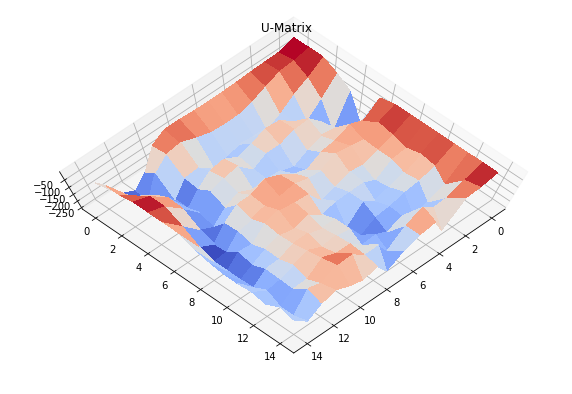

In [251]:
s = np.arange(0, som.units)
x, y = np.meshgrid(s, s)

fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
plt.title("U-Matrix")
ax.view_init(80, 45)
surf = ax.plot_surface(x, y, umatrix, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

Not much better than the example using t-SNE. We could see some clusters, but as the same case as PCA the Autoencoder could not generate the lastent space that fully separate the data... Well in this case, perhaps the Autoencoder needs to be tunned or reformulate in a way that could mimic in a way whats t-SNE do. 